# Cloud Detection on ASIVA Images Using Deep Learning

This project is carried out by Brock Taylor

The dataset of this project is obtained from the ASIVA instrument operated by CFHT at the summit of Mauna Kea (https://www.cfht.hawaii.edu/~asiva).


## What is ASIVA?

<center> todo


## What is CNN (Convolutional Neural Network) ?

CNN stands for Convolutional Neural Network which is a specializaed neural network for processing data that has an input shape like a 2D matrix like images. CNN's are typically used for image detection and classification.

## A. BUSINESS UNDERSTANDING


### Context

### Content

The dataset is organized into 3 folders (train, test, val) and contains subfolders of each image category 




## B. DATA UNDERSTANDING

### Installation the Libraries

In [34]:
!pip3 install opendatasets --upgrade --quiet

### Import Libraries


In [108]:
# Import libraries
import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
import opendatasets as od

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import random
from pathlib import Path #to be able to use functions using path


# Data science tools
import pandas as pd # data processing
import numpy as np # linear algebra

# Tensorflow for GPU
import tensorflow as tf
from tensorflow.compat.v1 import Session, ConfigProto, set_random_seed
from tensorflow.python.client import device_lib

# Keras library for Modeling
import keras
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras.constraints import max_norm
from keras import backend as K

# OpenCV
import cv2

# Resize images
from skimage.io import imread
from skimage.transform import resize

# Scikit-learn library
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import auc as AUC

# Visualizations
from PIL import Image
import imgaug as aug
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.image as mimg # images
%matplotlib inline
import seaborn as sns
import plotly.express as px

### Downloading the data

In [36]:
# Directories where you'll store the data
base_dir = Path("./Images/")


In [37]:
# Directories for the training, validation, and test splits
train_dir = base_dir /"train/" 
val_dir = base_dir /"val/"
test_dir = base_dir /"test/"

### Changing the environment CPU to GPU (Check the GPU Environment)

In [38]:
tf.__version__

'2.13.0'

In [39]:
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

### Data Loading

#### Data Loading for Train Dataset

In [40]:
os.listdir(train_dir)

['clear', 'cloudy']

In [41]:
train_clear_dir = train_dir /"clear" #to set the path to the clears in train set
train_cloudy_dir = train_dir /"cloudy" #to set the path to the cloudys in train set

#### Data Loading for Validation Dataset

In [42]:
os.listdir(val_dir)

['clear', 'cloudy']

In [43]:
valid_clear_dir = val_dir /"clear" #to set the path to the clears in validation set
valid_cloudy_dir = val_dir /"cloudy" #to set the path to the cloudys in validation set

#### Data Loading for Test Dataset

In [44]:
os.listdir(test_dir)

['clear', 'cloudy']

In [45]:
test_clear_dir = test_dir /"clear" #to set the path to the clears in test set
test_cloudy_dir = test_dir /"cloudy" #to set the path to the cloudys in test set

### Labeling

#### Setting the dataset for training

In [46]:
train_clear= train_clear_dir.glob("*.png") #to take the clear images from train set 
train_cloudy=train_cloudy_dir.glob("*.png") #to take the cloudy images from the train set
train_set=[]#to add all the train data into one list, we created a blank list

In [47]:
for img in train_clear: #to add every image of clears in trainset to the list
  train_set.append((img, 0)) #we add 0 with clear images as label
for img in train_cloudy:#to add every image of cloudys in trainset to the list
  train_set.append((img, 1)) #we add 1 with cloudy images as label

In [48]:
print(train_set[:15]) #to check what our list look like

[(WindowsPath('Images/train/clear/asiva20230621000.png'), 0), (WindowsPath('Images/train/clear/asiva202306210000.png'), 0), (WindowsPath('Images/train/clear/asiva202306210002.png'), 0), (WindowsPath('Images/train/clear/asiva202306210003.png'), 0), (WindowsPath('Images/train/clear/asiva202306210004.png'), 0), (WindowsPath('Images/train/clear/asiva202306210005.png'), 0), (WindowsPath('Images/train/clear/asiva202306210006.png'), 0), (WindowsPath('Images/train/clear/asiva202306210007.png'), 0), (WindowsPath('Images/train/clear/asiva202306210012.png'), 0), (WindowsPath('Images/train/clear/asiva202306210013.png'), 0), (WindowsPath('Images/train/clear/asiva202306210014.png'), 0), (WindowsPath('Images/train/clear/asiva202306210015.png'), 0), (WindowsPath('Images/train/clear/asiva202306210016.png'), 0), (WindowsPath('Images/train/clear/asiva202306210017.png'), 0), (WindowsPath('Images/train/clear/asiva202306210018.png'), 0)]


In [49]:
train_set=pd.DataFrame(train_set, columns=["image", "label"], index=None)#to create a dataframe from the list, so that we can use dataframe features

In [50]:
train_set.head() #to see the first 5 rows of our dataframe, only clears are shown since we added them first.

,image,label
0,Images\train\clear\asiva20230621000.png,0
1,Images\train\clear\asiva202306210000.png,0
2,Images\train\clear\asiva202306210002.png,0
3,Images\train\clear\asiva202306210003.png,0
4,Images\train\clear\asiva202306210004.png,0


In [51]:
train_set=train_set.sample(frac=1) #to shuffle all the rows in dataframe so that we can see clear and cloudy in random
train_set=train_set.reset_index(drop=True) #to set the indexes as if first time
train_set.head()

,image,label
0,Images\train\clear\asiva202306212134_rot90.png,0
1,Images\train\clear\asiva202306212035_flipLR.png,0
2,Images\train\clear\asiva202306220219_rot270.png,0
3,Images\train\cloudy\asiva202301252312_rot90.png,1
4,Images\train\cloudy\asiva202301251944_rot180.png,1


#### Setting the dataset for valdiation

In [52]:
valid_clear= valid_clear_dir.glob("*.png") #to take the clear images from validation set 
valid_cloudy=valid_cloudy_dir.glob("*.png") #to take the cloudy images from the validation set
valid_set=[] #to add all the validation data into one list, we created a blank list

In [53]:
for img in valid_clear: #to add every image of clears in validationset to the list
  valid_set.append((img, 0)) #we add 0 with clear images as label
for img in valid_cloudy:#to add every image of cloudys in validationset to the list
  valid_set.append((img, 1)) #we add 1 with cloudy images as label


In [54]:
print(valid_set[:15]) #to check what our list look like

[(WindowsPath('Images/val/clear/asiva202306210008.png'), 0), (WindowsPath('Images/val/clear/asiva202306210009.png'), 0), (WindowsPath('Images/val/clear/asiva202306222353.png'), 0), (WindowsPath('Images/val/clear/asiva202306222353_flipLR.png'), 0), (WindowsPath('Images/val/clear/asiva202306222353_flipTB.png'), 0), (WindowsPath('Images/val/clear/asiva202306222353_rot180.png'), 0), (WindowsPath('Images/val/clear/asiva202306222353_rot270.png'), 0), (WindowsPath('Images/val/clear/asiva202306222353_rot90.png'), 0), (WindowsPath('Images/val/clear/asiva202306222354.png'), 0), (WindowsPath('Images/val/clear/asiva202306222354_flipLR.png'), 0), (WindowsPath('Images/val/clear/asiva202306222354_flipTB.png'), 0), (WindowsPath('Images/val/clear/asiva202306222354_rot180.png'), 0), (WindowsPath('Images/val/clear/asiva202306222354_rot270.png'), 0), (WindowsPath('Images/val/clear/asiva202306222354_rot90.png'), 0), (WindowsPath('Images/val/clear/asiva202306222355.png'), 0)]


In [55]:
valid_set=pd.DataFrame(valid_set, columns=["image", "label"], index=None)#to create a dataframe from the list, so that we can use dataframe features
valid_set.head() #to see the first 5 rows of our dataframe, only clears are shown since we added them first.

,image,label
0,Images\val\clear\asiva202306210008.png,0
1,Images\val\clear\asiva202306210009.png,0
2,Images\val\clear\asiva202306222353.png,0
3,Images\val\clear\asiva202306222353_flipLR.png,0
4,Images\val\clear\asiva202306222353_flipTB.png,0


In [56]:
valid_set=valid_set.sample(frac=1) #to shuffle all the rows in dataframe so that we can see clear and cloudy in random
valid_set=valid_set.reset_index(drop=True) #to set the indexes as if first time
valid_set.head()

,image,label
0,Images\val\cloudy\asiva202302042240.png,1
1,Images\val\clear\asiva202306272306_rot270.png,0
2,Images\val\clear\asiva202306272227_rot180.png,0
3,Images\val\cloudy\asiva202304112104_flipTB.png,1
4,Images\val\cloudy\asiva202302042313_rot180.png,1


#### Setting the dataset for test

In [57]:
test_clear= test_clear_dir.glob("*.png") #to take the clear images from test set 
test_cloudy=test_cloudy_dir.glob("*.png") #to take the cloudy images from the test set
test_set=[]#to add all the test data into one list, we created a blank list

In [58]:
for img in test_clear: #to add every image of clears in test set to the list
  test_set.append((img, 0)) #we add 0 with clear images as label
for img in test_cloudy:#to add every image of cloudys in test set to the list
  test_set.append((img, 1)) #we add 1 with cloudy images as label


In [59]:
print(test_set[:15]) #to check what our list look like

[(WindowsPath('Images/test/clear/asiva202306210010.png'), 0), (WindowsPath('Images/test/clear/asiva202306210011.png'), 0), (WindowsPath('Images/test/clear/asiva202306272356_rot180.png'), 0), (WindowsPath('Images/test/clear/asiva202306272356_rot270.png'), 0), (WindowsPath('Images/test/clear/asiva202306272356_rot90.png'), 0), (WindowsPath('Images/test/clear/asiva202306272357.png'), 0), (WindowsPath('Images/test/clear/asiva202306272357_flipLR.png'), 0), (WindowsPath('Images/test/clear/asiva202306272357_flipTB.png'), 0), (WindowsPath('Images/test/clear/asiva202306272357_rot180.png'), 0), (WindowsPath('Images/test/clear/asiva202306272357_rot270.png'), 0), (WindowsPath('Images/test/clear/asiva202306272357_rot90.png'), 0), (WindowsPath('Images/test/clear/asiva202306272358.png'), 0), (WindowsPath('Images/test/clear/asiva202306272358_flipLR.png'), 0), (WindowsPath('Images/test/clear/asiva202306272358_flipTB.png'), 0), (WindowsPath('Images/test/clear/asiva202306272358_rot180.png'), 0)]


In [60]:
test_set=pd.DataFrame(test_set, columns=["image", "label"], index=None)#to create a dataframe from the list, so that we can use dataframe features
test_set.head() #to see the first 5 rows of our dataframe, only clears are shown since we added them first.

,image,label
0,Images\test\clear\asiva202306210010.png,0
1,Images\test\clear\asiva202306210011.png,0
2,Images\test\clear\asiva202306272356_rot180.png,0
3,Images\test\clear\asiva202306272356_rot270.png,0
4,Images\test\clear\asiva202306272356_rot90.png,0


In [61]:
test_set=test_set.sample(frac=1) #to shuffle all the rows in dataframe so that we can see clear and cloudy in random
test_set=test_set.reset_index(drop=True) #to set the indexes as if first time
test_set.head()

,image,label
0,Images\test\clear\asiva202306280029.png,0
1,Images\test\clear\asiva202306280124_flipLR.png,0
2,Images\test\clear\asiva202306280226_rot180.png,0
3,Images\test\clear\asiva202306280214_flipTB.png,0
4,Images\test\cloudy\asiva202304172240_rot270.png,1


### Data Visualization

In [62]:
# clear Image
train_clear_count= train_set.loc[train_set["label"]==0]["image"].count()
print("Total number of clear images:", train_clear_count)

Total number of clear images: 4393


In [63]:
# Pneumonia Image
train_cloudy_count= train_set.loc[train_set["label"]==1]["image"].count()
print("Total number of cloudy images:", train_cloudy_count)

Total number of cloudy images: 5537


#### clear / cloudy Image Visualization for Train Dataset

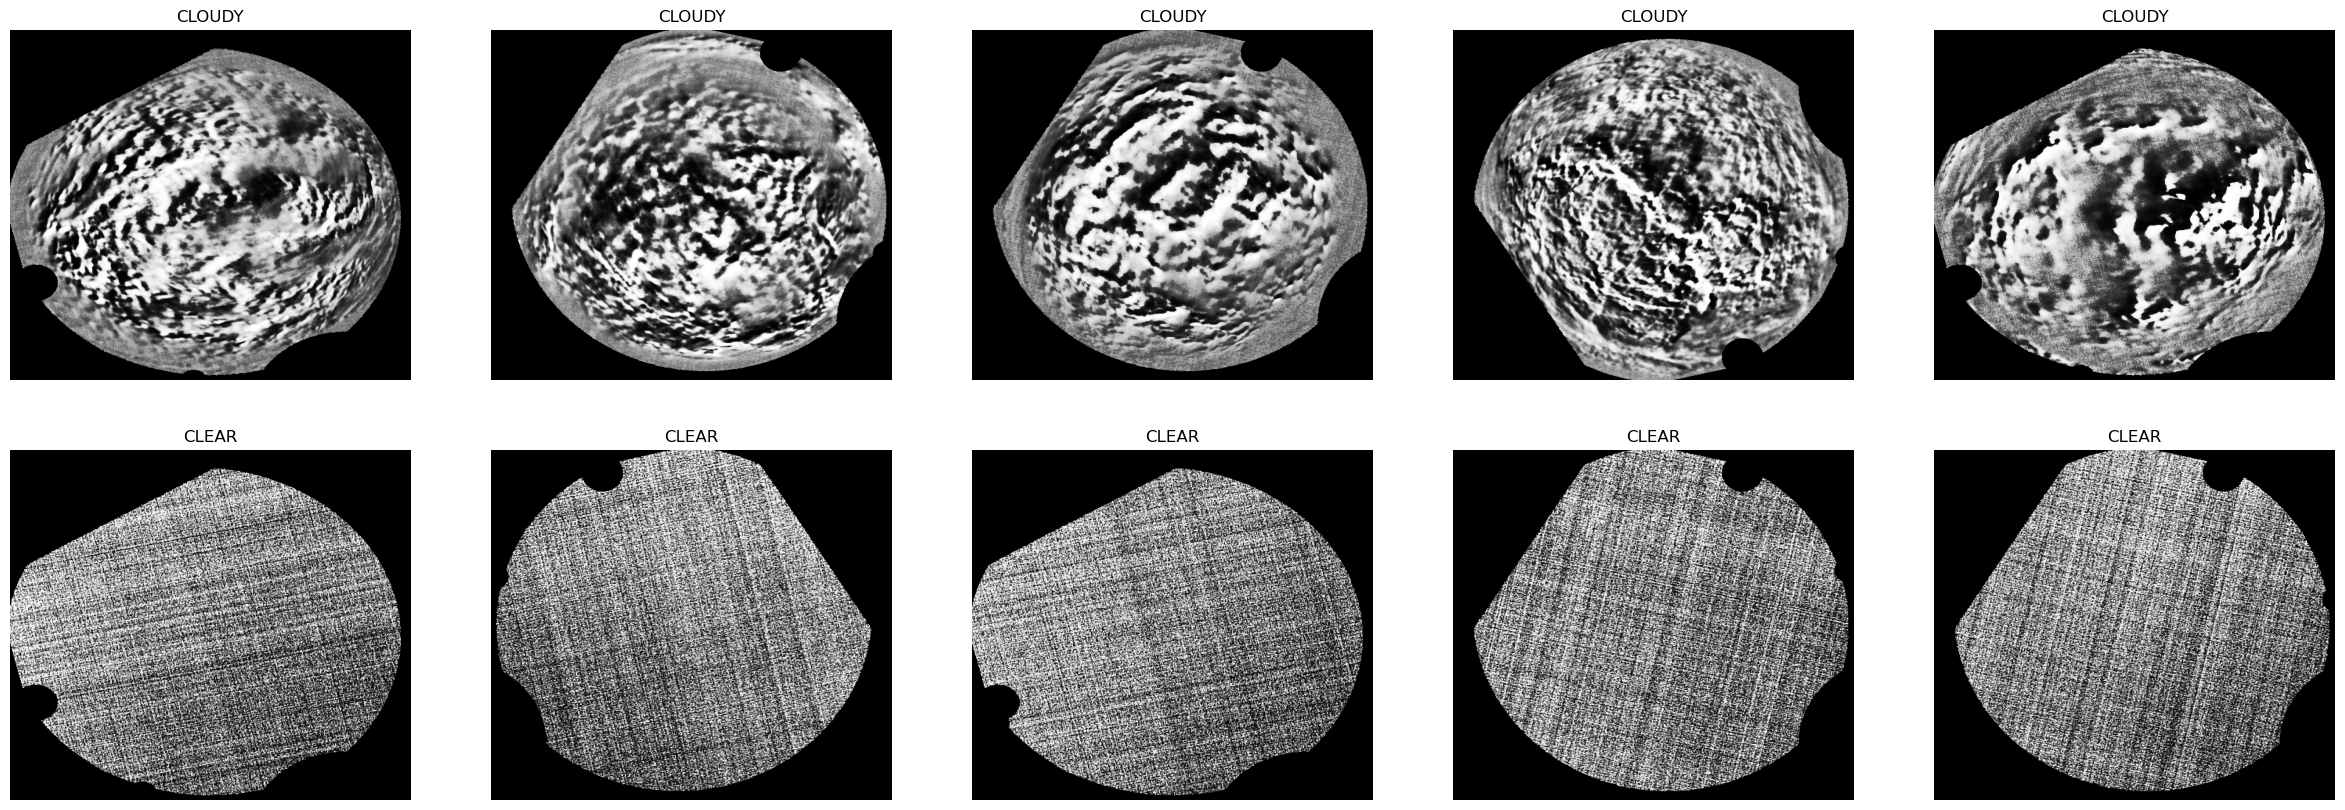

In [64]:
# Get few samples for both the classes
cloudy_samples = (train_set[train_set["label"] == 1]["image"].iloc[:5]).tolist()
clear_samples = (train_set[train_set["label"] == 0]["image"].iloc[:5]).tolist()

# Concate the data in a single list and del the above two list
samples = cloudy_samples + clear_samples
del cloudy_samples, clear_samples

# Plot the data
f, ax = plt.subplots(2,5, figsize = (30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i % 5].imshow(img, cmap='gray')
    if i < 5:
        ax[i//5, i % 5].set_title("CLOUDY")
    else:
        ax[i//5, i % 5].set_title("CLEAR")
    ax[i//5, i % 5].axis('off')
    ax[i//5, i % 5].set_aspect('auto')
plt.show()

#### Plotting the Data Distribution

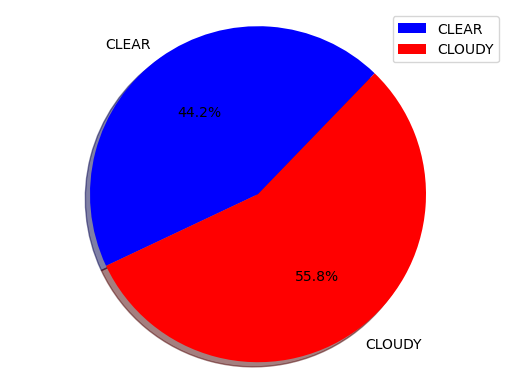

In [65]:
fig1,ax1= plt.subplots()
sizes=[train_clear_count, train_cloudy_count]
ax1.pie(sizes, startangle=46 ,labels=["CLEAR","CLOUDY"], autopct="%1.1f%%", shadow=True, colors=["b","r"])
ax1.axis("equal")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Case Distribution')

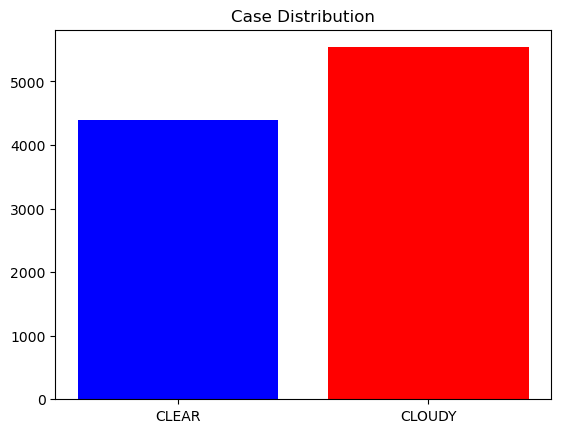

In [66]:
fig2, ax2=plt.subplots()
ax2.bar(height=sizes, x=["CLEAR", "CLOUDY"], color=["blue", "red"])
plt.title("Case Distribution")

According to this result, we have imbalanced image dataset. We will increase the "clear" image dataset using Data Augmentation to correct this imbalance.

### Data Preparation

#### Data Distribution

In [67]:
labels = ['cloudy', 'clear']
img_size_x = 136 #544
img_size_y = 128 #512

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # Reshaping images to preferred size
                resized_arr = cv2.resize(img_arr, (img_size_x, img_size_y))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
     
    return np.array(data, dtype='object')


In [68]:
train = get_training_data(train_dir)

In [69]:
test = get_training_data(test_dir)

In [70]:
val = get_training_data(val_dir)

In [71]:
# initialize multiple lists
X_train, X_val, X_test = ([], ) * 3
y_train, y_val, y_test = ([], ) * 3

In [72]:
for feature, label in train:
#    print (feature, label)
    X_train.append(feature)
    y_train.append(label)

In [73]:
for feature, label in val:
#    print (feature, label)
    X_val.append(feature)
    y_val.append(label)


In [74]:
for feature, label in test:
#    print (feature, label)
    X_test.append(feature)
    y_test.append(label)

We perform a grayscale clearization to reduce the effect of illumination's differences. Moreover the CNN converges faster on [0..1] data than on [0..255].

#### Data clearization

In [75]:
X_train = np.array(X_train) / 255

In [76]:
X_val = np.array(X_val) / 255

In [77]:
X_test = np.array(X_test) / 255

#### Reshaping the data for deep learning model

In [78]:
X_train = X_train.reshape (-1, img_size_x, img_size_y, 1)
y_train = np.array(y_train)

In [79]:
X_val = X_val.reshape(-1, img_size_x, img_size_y, 1)
y_val = np.array(y_val)

In [80]:
X_test = X_test.reshape(-1, img_size_x, img_size_y, 1)
y_test = np.array(y_test)

## C. DATA AUGMENTATION

To avoid the overfitting problem, we need to artificially expand our dataset. We can further enlarge your existing dataset. The idea is to manipulate the training data with small transformations to reproduce the variations. Approaches that modify the training data to change the sequence representation while keeping the label the same are known as data augmentation techniques. Some popular magnifications people use are grayscales, horizontal flips, vertical flips, random crops, dithering, offsets, rotations, and much more. By applying just a few of these transformations to our training data, we can easily double or triple the number of training samples and create a very robust model. 

### Getting Train Generator

In [81]:
# clearize and augment images
image_generator = ImageDataGenerator(
  featurewise_center = False, # set input mean to 0 over the dataset
  samplewise_center = False, # set each sample mean to 0
  featurewise_std_normalization = False, #divide inputs by std of the dataset
  samplewise_std_normalization = False, # divide each input by its std
  zca_whitening=False,  # apply ZCA whitening
  rotation_range =30, #randomly rotate images in the range
  zoom_range = 0.2, #randomly zoom image
  width_shift_range = 0.1, #randomly shift images horizontally
  height_shift_range = 0.1, #randomly shift images vertically
  horizontal_flip = True, #randomly flip images
  vertical_flip = False) #randomly flip images
  
image_generator.fit(X_train)

For the data augmentation, we choosed to:

1. Randomly rotate some training images by 30 degrees
2. Randomly Zoom by 20% saome training images
3. Randomly shift imags horizontally by 10% of the width
4. Randomly shift images vertically by 10% of the height
5. Randomly flip images horizontally



## D. DATA MODELLING

### D.1 Building CNN Model

In [82]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (img_size_x,img_size_y,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 136, 128, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 136, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 68, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 68, 64, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 68, 64, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 68, 64, 64)        2

In [83]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [84]:
history = model.fit(image_generator.flow(X_train, y_train, batch_size=32), epochs=15, 
                    validation_data=image_generator.flow(X_val, y_val), 
                    callbacks=[learning_rate_reduction])


Epoch 1/15
518/518 [==============================] - 728s 1s/step - loss: 0.1101 - accuracy: 0.9866 - val_loss: 21.4845 - val_accuracy: 0.4423 - lr: 0.0010
Epoch 2/15
518/518 [==============================] - 677s 1s/step - loss: 0.0184 - accuracy: 0.9963 - val_loss: 0.0508 - val_accuracy: 0.9836 - lr: 0.0010
Epoch 3/15
518/518 [==============================] - 681s 1s/step - loss: 0.0150 - accuracy: 0.9967 - val_loss: 0.1280 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 4/15
518/518 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9979
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
518/518 [==============================] - 680s 1s/step - loss: 0.0094 - accuracy: 0.9979 - val_loss: 0.0992 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 5/15
518/518 [==============================] - 647s 1s/step - loss: 0.0012 - accuracy: 0.9995 - val_loss: 0.1193 - val_accuracy: 0.9761 - lr: 3.0000e-04
Epoch 6/15
518/518 [==============================] - 

In [85]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

518/518 [==============================] - 117s 226ms/step - loss: 3.4444 - accuracy: 0.5577
Loss of the model is -  3.444352149963379
518/518 [==============================] - 116s 223ms/step - loss: 3.4444 - accuracy: 0.5577
Accuracy of the model is -  55.76574206352234 %


## E.EVALUATION

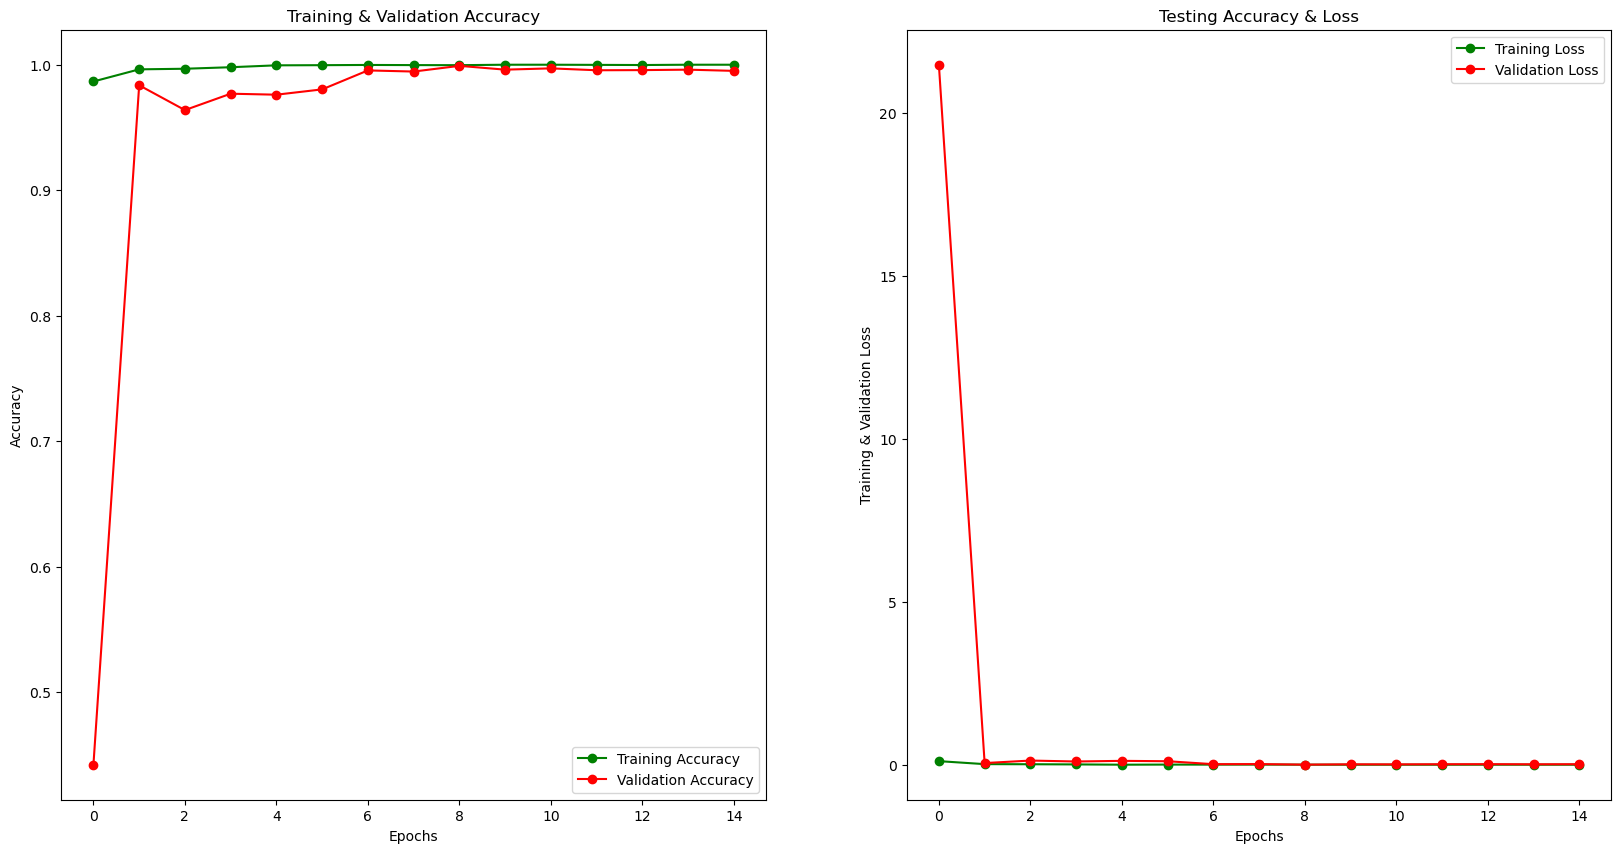

In [86]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [98]:
pred = model.predict(X_test)
predictions = (pred > 0.5).astype("int32")
predictions = predictions.reshape(1, -1)[0]
predictions[:15]

518/518 [==============================] - 94s 181ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

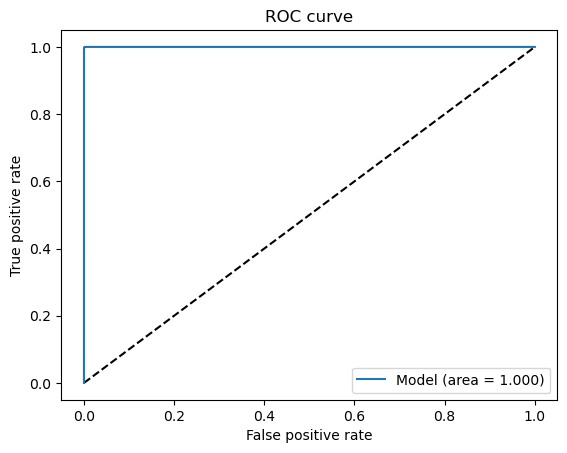

In [109]:

fpr, tpr, thresholds = roc_curve(y_test, pred)
auc = AUC(fpr, tpr)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [104]:
print(classification_report(y_test, predictions, target_names = ['cloudy (Class 0)','clear (Class 1)']))

                  precision    recall  f1-score   support

cloudy (Class 0)       0.56      1.00      0.72      9227
 clear (Class 1)       0.00      0.00      0.00      7319

        accuracy                           0.56     16546
       macro avg       0.28      0.50      0.36     16546
    weighted avg       0.31      0.56      0.40     16546



C:\Users\Brock\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Brock\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Brock\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
cm = confusion_matrix(y_test, predictions)
cm


array([[9227,    0],
       [7319,    0]], dtype=int64)

In [90]:
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])


<Axes: >

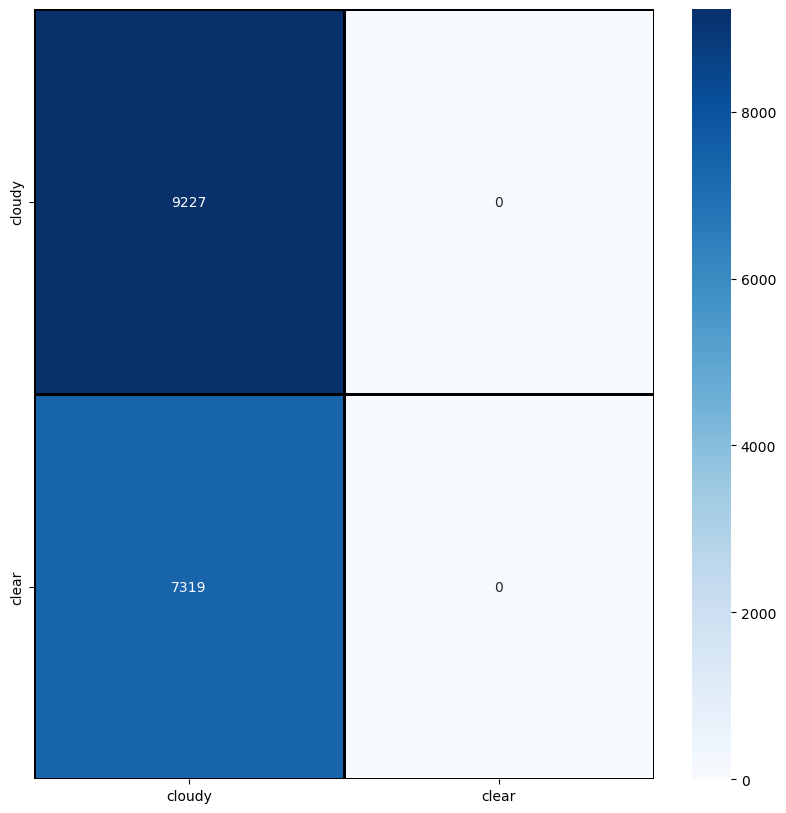

In [91]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [92]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]


## F. PROOF

### F.1 Some of the Correctly Predicted Classes

C:\Users\Brock\AppData\Local\Temp\ipykernel_11816\4137811992.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, i+1)


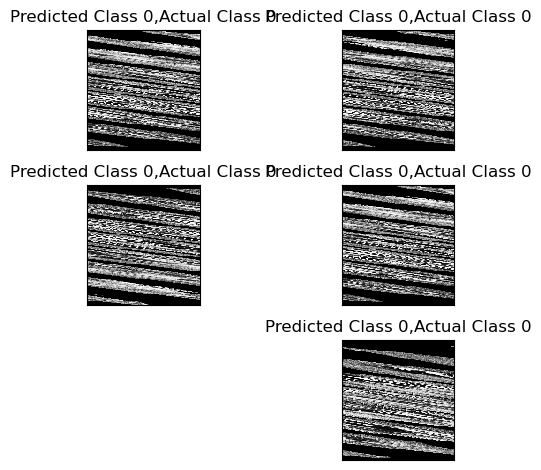

In [93]:
i = 0
for c in correct[:6]:
    plt.subplot(3, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(img_size_x, img_size_y), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(
        predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1


### F.2 Some of the Incorrectly Predicted Class

C:\Users\Brock\AppData\Local\Temp\ipykernel_11816\76822628.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, i+1)


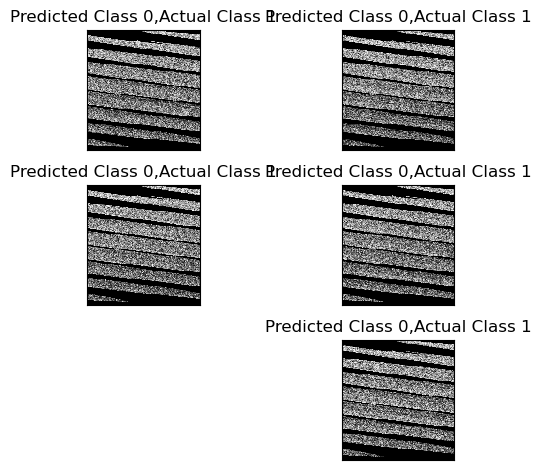

In [94]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(img_size_x, img_size_y), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1


## G. RESOURCES

**Website Resources**

* ***Tensorflow - Keras Documentations***
    * https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
    * https://keras.io/api/layers/convolution_layers/

* **Book Resouces**
    * Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow
    * Deep Learning with Python
    * Tensorflow for Deep Learning
    * Programming Computer Vision with Python